<a href="https://colab.research.google.com/github/rakibulhaque9954/sec-22-Image-generation-VAEs/blob/main/sec_22_Image_generation_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.layers import Layer, Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input

from keras.optimizers import Adam


# Dataset Preparation and Preprocessing

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis = 0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255.

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits) # converting tensor format

In [5]:
len(dataset)

70000

In [6]:
BATCH_SIZE = 128
LATENT_DIM = 2 # basically how big you want your encodings to be, its like choosing the right size to compress image to
# bigger the latent dim more the data stored or details and vice versa, it all depends on the type of dataset

In [7]:
train_dataset = (
    dataset
    .shuffle(buffer_size= 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Modeling

## Encoder

### Sampling Layer

In [9]:
class Sampling(Layer):

  def call(self, inputs):
    mean, log_var = inputs

    return mean + tf.math.exp(0.5 ) * tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))


In [10]:
encoder_inputs = Input(shape=(28, 28, 1))

x = Conv2D(32, 3, activation = 'relu', strides = 2, padding ='same')(encoder_inputs)
x = Conv2D(64, 3, activation = 'relu', strides = 2, padding ='same')(x)
# extracting features

x = Flatten()(x)
x = Dense(16, activation = 'relu')(x)
# flattening it to pass to extract mean and std

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean, log_var]) # all in accordance of the formula

encoder_model = Model(encoder_inputs, [mean, log_var, z], name = 'encoder')
encoder_model.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

## Decoder

we will reverse engineer the outputs from the encoder and make the decoder upsample it using Conv2D Transpose, where after output from encoder we get shape(Batch, Latent_dim) so this has to be converted to (Batch, mean, std, Z) and in such a way that the size we desire from the decoder as the original image is of the same when its converted. This is the reconstruction phase.

In [11]:
latent_inputs = Input(shape=(LATENT_DIM))

x = Dense(7 * 7 * 64, activation = 'relu')(latent_inputs)
x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2DTranspose(32, 3, activation = 'relu', strides = 2, padding = 'same')(x)

decoder_output = Conv2DTranspose(1, 3, activation = 'sigmoid', padding = 'same')(x)
decoder_model = Model(latent_inputs, decoder_output, name = 'decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

# Full VAE Model

In [12]:
vae_input = Input(shape = (28,28,1), name = "vae_input")

x = encoder_model(vae_input)

output = decoder_model(x)

vae = Model(vae_input, output, name = "vae_model")

vae.summary()

Model: "vae_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 vae_input (InputLayer)      [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  69076     ['vae_input[0][0]']           
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            65089     ['encoder[0][0]',             
                                                                     'encoder[0][1]',     

# Training

In [13]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 30

In [14]:
def custom_loss(y_true, y_pred, mean, log_var):

  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis = (1, 2)))

  loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))

  return reconstruction_loss + tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

In [15]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z, mean, log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true, y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss, vae.trainable_weights) # calculates the gradient descent and helps in updating the weights
  OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss

The loss function quantifies how well the neural network is performing; lower values indicate better performance.
Gradients (partial derivatives) of the loss with respect to the model's weights are calculated. These gradients indicate the direction and magnitude of change needed to minimize the loss.
Gradient descent adjusts the model's weights in the direction opposite to the gradients. This means it makes small changes to the weights to reduce the loss iteratively.
By iteratively adjusting the weights based on the gradients, the neural network aims to find the optimal set of weights that minimizes the loss, improving its performance over time.


In [16]:
def model_train(epochs):
  for epoch in range(1, epochs + 1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')

In [17]:
model_train(EPOCHS)

Training starts for epoch number 1
Training Loss is:  tf.Tensor(173.51419, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is:  tf.Tensor(162.71078, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is:  tf.Tensor(156.87491, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is:  tf.Tensor(139.24976, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is:  tf.Tensor(152.6119, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is:  tf.Tensor(155.67575, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is:  tf.Tensor(141.20816, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is:  tf.Tensor(147.49442, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is:  tf.Tensor(149.42262, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is:  tf.Tensor(144.34372, shape=(), dtype=float32)


# Overriding train_step Method

In [29]:
class VAE(tf.keras.Model):
  def __init__(self, encoder_model, decoder_model):
    super(VAE,self).__init__()
    self.encoder = encoder_model
    self.decoder = decoder_model
    self.loss_tracker = tf.keras.metrics.Mean(name='loss')

  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z, mean,log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = custom_loss(y_true, y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss, self.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}

In [30]:
model = VAE(encoder_model, decoder_model)
model.compile(optimizer = OPTIMIZER)
model.fit(train_dataset, epochs = 20, batch_size = 128,)

Epoch 1/20
547/547 [==============================] - 6s 7ms/step - loss: 142.2537
Epoch 2/20
547/547 [==============================] - 4s 7ms/step - loss: 142.0887
Epoch 3/20
547/547 [==============================] - 4s 7ms/step - loss: 141.9158
Epoch 4/20
547/547 [==============================] - 4s 7ms/step - loss: 141.8826
Epoch 5/20
547/547 [==============================] - 4s 7ms/step - loss: 141.7135
Epoch 6/20
547/547 [==============================] - 4s 7ms/step - loss: 141.6911
Epoch 7/20
547/547 [==============================] - 4s 7ms/step - loss: 141.5606
Epoch 8/20
547/547 [==============================] - 4s 7ms/step - loss: 141.4004
Epoch 9/20
547/547 [==============================] - 4s 7ms/step - loss: 141.4878
Epoch 10/20
547/547 [==============================] - 4s 7ms/step - loss: 141.2488
Epoch 11/20
547/547 [==============================] - 4s 7ms/step - loss: 141.1174
Epoch 12/20
547/547 [==============================] - 4s 7ms/step - loss: 141.0309
E

# Testing

In [18]:
scale = 1
n = 16

In [19]:
grid_x = np.linspace(-scale, scale, 16)
grid_y = np.linspace(-scale, scale, 16)

In [20]:
print(grid_x,grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 18ms/step


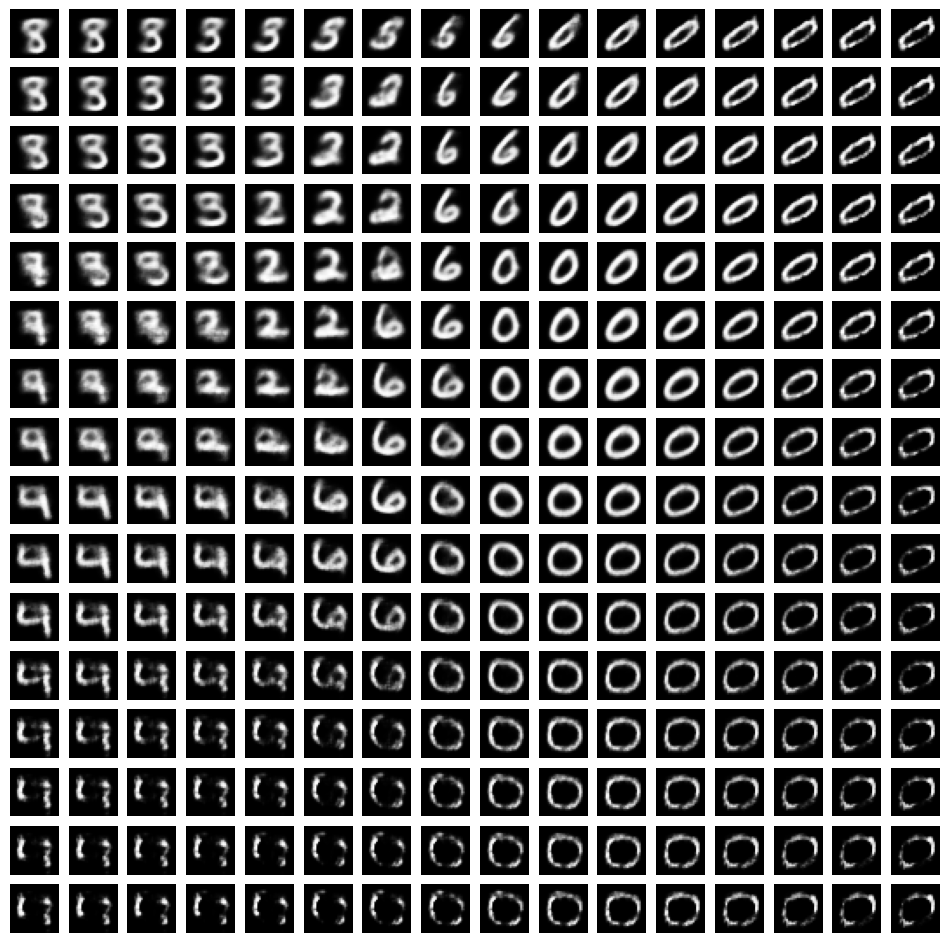

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
k = 0
for i in grid_x:
  for j in grid_y:
    ax = plt.subplot(n, n, k+1)

    input = tf.constant([[i,j]])
    out = model.decoder.predict(input)[0][...,0]
    plt.imshow(out, cmap = "Greys_r")
    plt.axis('off')
    k += 1

In [34]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train, -1).astype('float32') / 255

1875/1875 [==============================] - 3s 1ms/step


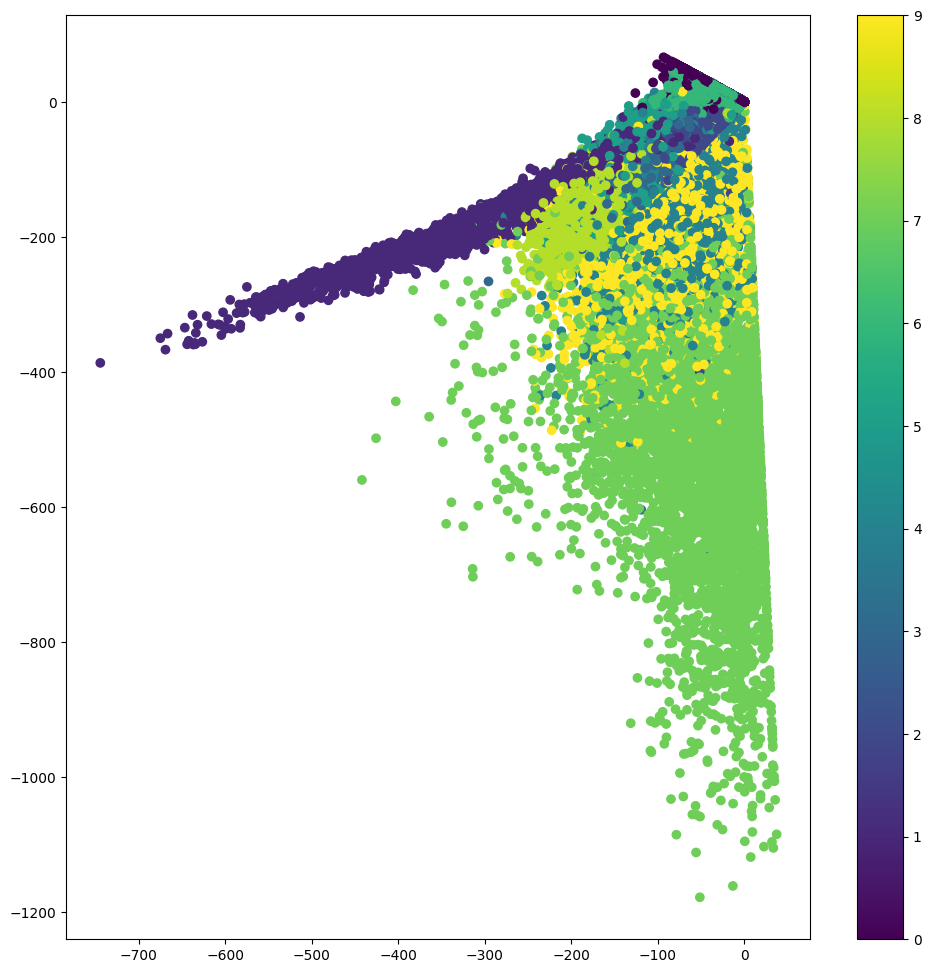

In [35]:
z, _, _ = model.encoder.predict(x_train) # encoder model
plt.figure(figsize=(12,12))
plt.scatter(z[:, 0],z[:, 1], c = y_train)
plt.colorbar()
plt.show()